# Introduction to single-cell multi-view profiler (scMVP)
In this introductory tutorial, we present the different tasks of a scMVP workflow
1. Loading the multi-omics data
2. Training the multi-view model
3. Retrieving the common latent space and imputed multi-omics values
4. Perform cell clustering and differential expression 
5. Visualize the common latent space and clustering with umap

In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scMVP.dataset import SciCarDemo, scienceDataset
from scMVP.models import VAE
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch
from scMVP.models.multi_vae import Multi_VAE

## Visualizing the latent space with scanpy
import scanpy as sc
import anndata


## Loading data

 loading the sci-CAR cell line dataset described in Junyue Cao et al. (2018).

* Junyue Cao, et al. "Joint profiling of chromatin accessibility and gene 
expression in thousands of single cells." Science 361.6409 (2018): 1380-1385. 

In [3]:
def allow_mmvae_for_test():
    print("Testing the basic tutorial scMVP")

test_mode = False
# define the repository for trained models
model_path = "dataset/pretrain_model/"
n_epochs_all = None
show_plot = True

dataset=SciCarDemo(dataset_name="CellLineMixture",data_path="dataset/sci_car/",
                   cell_meta="dataset/sci_car/GSM3271041_ATAC_sciCAR_A549_cell.txt")


[2021-01-23 22:43:18,240] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2021-01-23 22:43:33,991] INFO - scMVP.dataset.scMVP_dataloader | Loading source into dataset.
[2021-01-23 22:43:33,995] INFO - scMVP.dataset.scMVP_dataloader | Loading group into dataset.
[2021-01-23 22:43:33,997] INFO - scMVP.dataset.scMVP_dataloader | Loading experiment into dataset.
[2021-01-23 22:43:34,003] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2021-01-23 22:43:35,819] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-01-23 22:43:35,821] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-01-23 22:43:37,568] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-01-23 22:43:38,371] INFO - scMVP.dataset.dataset | Downsampled from 4825 to 4825 cells


## Data preprocessing

In [4]:
def filter_dataset(dataset):
    high_count_genes = (dataset.X > 0).sum(axis=0).ravel() > 0.01 * dataset.X.shape[0]
    dataset.update_genes(high_count_genes)
    dataset.subsample_genes(new_n_genes=10000)
    
    high_gene_count_cells = (dataset.X > 0).sum(axis=1).ravel() > 50
    #high_atac_cells = dataset.atac_expression.sum(axis=1) >= np.percentile(dataset.atac_expression.sum(axis=1), 10)
    high_atac_cells = dataset.atac_expression.sum(axis=1) >= np.percentile(dataset.atac_expression.sum(axis=1), 1)
    inds_to_keep = np.logical_and(high_gene_count_cells, high_atac_cells)
    dataset.update_cells(inds_to_keep)
    return dataset, inds_to_keep

if test_mode is False:
    dataset, inds_to_keep = filter_dataset(dataset)


[2021-01-23 22:44:04,956] INFO - scMVP.dataset.dataset | Downsampling from 113153 to 20403 genes
[2021-01-23 22:44:05,441] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-01-23 22:44:05,781] INFO - scMVP.dataset.dataset | Filtering non-expressing cells.
[2021-01-23 22:44:07,064] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-01-23 22:44:07,210] INFO - scMVP.dataset.dataset | Downsampled from 4825 to 4825 cells
[2021-01-23 22:44:08,772] INFO - scMVP.dataset.dataset | Downsampling from 20403 to 10000 genes
[2021-01-23 22:44:09,223] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-01-23 22:44:09,392] INFO - scMVP.dataset.dataset | Filtering non-expressing cells.
[2021-01-23 22:44:10,503] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-01-23 22:44:10,576] INFO - scMVP.dataset.dataset | Downsampled from 4825 to 4825 cells
[2021-01-23 22:44:12,116] INFO - scMVP.

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 
* __n_centroids__: Set the number of cell types
* __n_alfa__: Set the weight of KL loss

In [5]:
n_epochs = 30 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = False
use_cuda = False # True if using GPU
n_centroids = 5
n_alfa = 1.0

## Pre-training
runing pre-train vae to initialize the Gaussian Mixture Model

<All keys matched successfully>

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=10000, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=10000, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=1, bias=True)
    (var_encoder): Linear(in_features=1

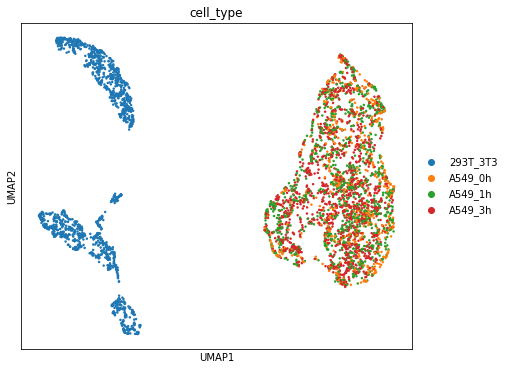

In [6]:
pre_vae = VAE(dataset.nb_genes, n_batch=256)
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5
)
is_test_pragram = False
if is_test_pragram:
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/GMM_pre_trainer.pkl' % model_path)

if os.path.isfile('%s/GMM_pre_trainer.pkl' % model_path):
    pre_trainer.model.load_state_dict(torch.load('%s/GMM_pre_trainer.pkl' % model_path))
    pre_trainer.model.eval()
else:
    #pre_trainer.model.init_gmm_params(dataset)
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/GMM_pre_trainer.pkl' % model_path)

# pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, dataset, indices=np.arange(len(dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# visulization
prior_adata = anndata.AnnData(X=dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = pd.Categorical(dataset.group)
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(prior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(prior_adata, color=["cell_type"], ax=ax, show=show_plot)

# Training scMVP
We now create the scMVP model and the trainer object.

If a pre-trained model already exist in the path, then load the same model rather than re-training it. This is particularly useful for large datasets.

In [7]:
multi_vae = Multi_VAE(dataset.nb_genes, len(dataset.atac_names), n_batch=256, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)

clust_index_gmm = trainer.model.init_gmm_params(latent)

is_test_pragram = False
if is_test_pragram:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/scMVP_multi_vae.pkl' % model_path)
if os.path.isfile('%s/scMVP_multi_vae.pkl' % model_path):
    trainer.model.load_state_dict(torch.load('%s/scMVP_multi_vae.pkl' % model_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/scMVP_multi_vae.pkl' % model_path)

<All keys matched successfully>

Multi_VAE(
  (RNA_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=10000, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (ATAC_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=87240, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(i

Plotting the likelihood change across the n epochs of training: blue for training error and orange for testing error.**

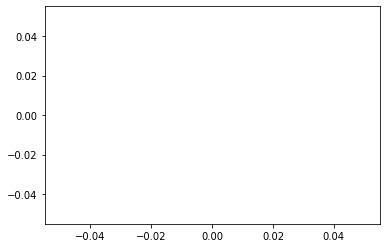

In [8]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.show()

# this plot will not show traing loss in epoch if use existed model

Query the imputed values via the `imputation` method of the posterior object and get common latent embedding. <br>
**Note for advanced users:** <br> imputation is an ambiguous term and there are two ways to perform imputation in scVI. The first way is to query the **mean of the negative binomial** distribution modeling the counts. This is referred to as `sample_rate` in the codebase and can be reached via the `imputation` method. The second is to query the **normalized mean of the same negative binomial** (please refer to the scVI manuscript). This is referred to as `sample_scale` in the codebase and can be reached via the `get_sample_scale` method. In differential expression for example, we of course rely on the normalized latent variable which is corrected for variations in sequencing depth.

In [9]:
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
imputed_values = full.sequential().imputation()
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()

sample_latents = torch.tensor([])
sample_labels = torch.tensor([])
rna_imputation = imputed_values[0]
atac_imputation = imputed_values[3]
temp_label = []
sample_latents = torch.tensor([])
samples = torch.tensor([])
sample_labels = torch.tensor([])
if len(imputed_values) >= 3:
    temp_label = imputed_values[2]
for tensors_list in range(int(len(imputed_values[0])/256)+1):
    if temp_label.any():
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256])) 
    else:
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(np.zeros(256))) 
    for temp_sample in temp_samples:
        #sample_latents = torch.cat((sample_latents, temp_sample[2].float()))
        sample_latents = torch.cat((sample_latents, temp_sample[0][0].float()))
        sample_labels = torch.cat((sample_labels, torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256]).float()))

## Cell clustering
Cell clustering and merging the rare clusters with less than 10 cells

In [10]:
clust_index_gmm = trainer.model.init_gmm_params(latent)
gmm_clus_index = clust_index_gmm.reshape(-1,1)
for i in range(len(np.unique(gmm_clus_index))):
    if len(gmm_clus_index[gmm_clus_index == i]) <= 10:
        for j in range(len(np.unique(gmm_clus_index))):
            if len(gmm_clus_index[gmm_clus_index == j]) > 100:
                gmm_clus_index[gmm_clus_index == i] = j
                break
unique_gmm_clus_index = np.unique(gmm_clus_index)
for i in range(len(unique_gmm_clus_index)):
    gmm_clus_index[gmm_clus_index == unique_gmm_clus_index[i]] = i

Visualizing common latent embedding and cell clustering by scMVP

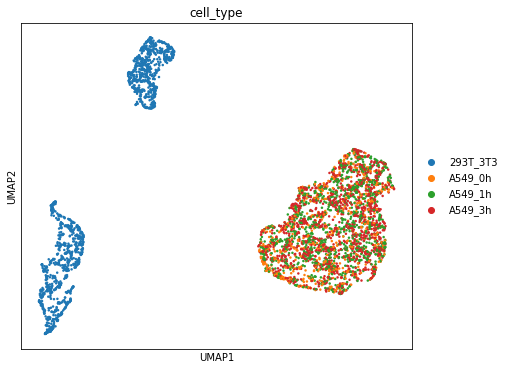

In [12]:
posterior_adata = anndata.AnnData(X=rna_imputation)
posterior_adata.obsm["X_multi_vi"] = latent
posterior_adata.obs['cell_type'] = pd.Categorical(dataset.group)
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
# imputation labels


## Differential gene analysis
Differential gene identification with scanpy.

/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/anndata-0.7.4-py3.7.egg/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'louvain' as categorical


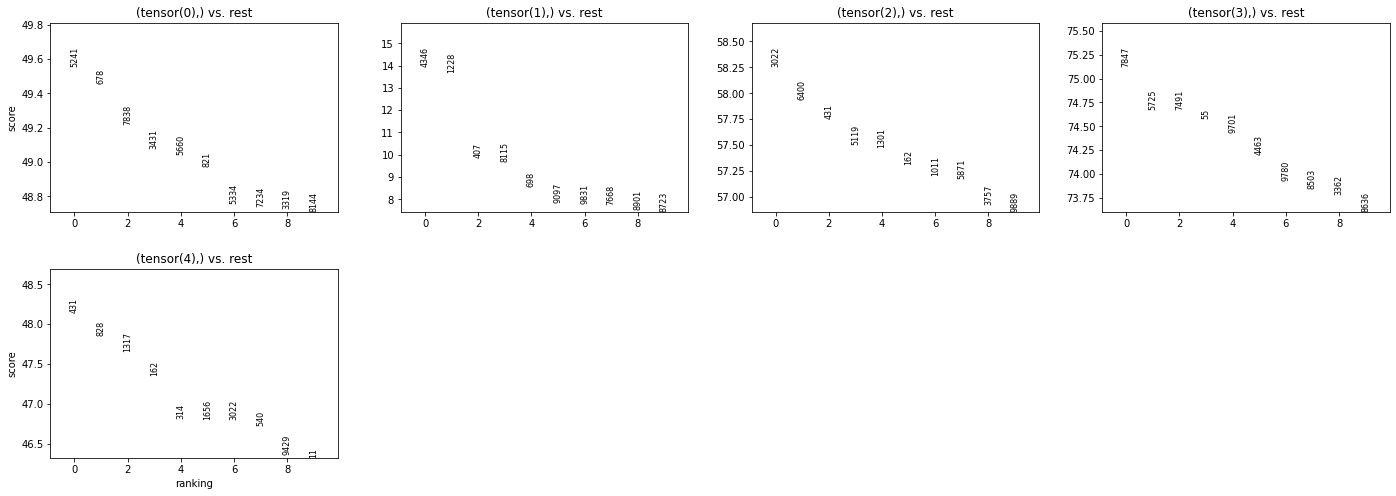

In [13]:
posterior_adata.obs['louvain'] = torch.tensor(gmm_clus_index.reshape(-1,1))
sc.tl.rank_genes_groups(posterior_adata, 'louvain')
sc.pl.rank_genes_groups(posterior_adata, n_genes=10, sharey=False)
diff_top_gene_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_set = (diff_top_gene_set['names'])
diff_top_gene_pvalue_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_pvalue_set = (diff_top_gene_pvalue_set['pvals_adj'])
diff_top_gene_foldchange_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_foldchange_set = (diff_top_gene_foldchange_set['logfoldchanges'])

Differential ATAC peaks analysis with scanpy.

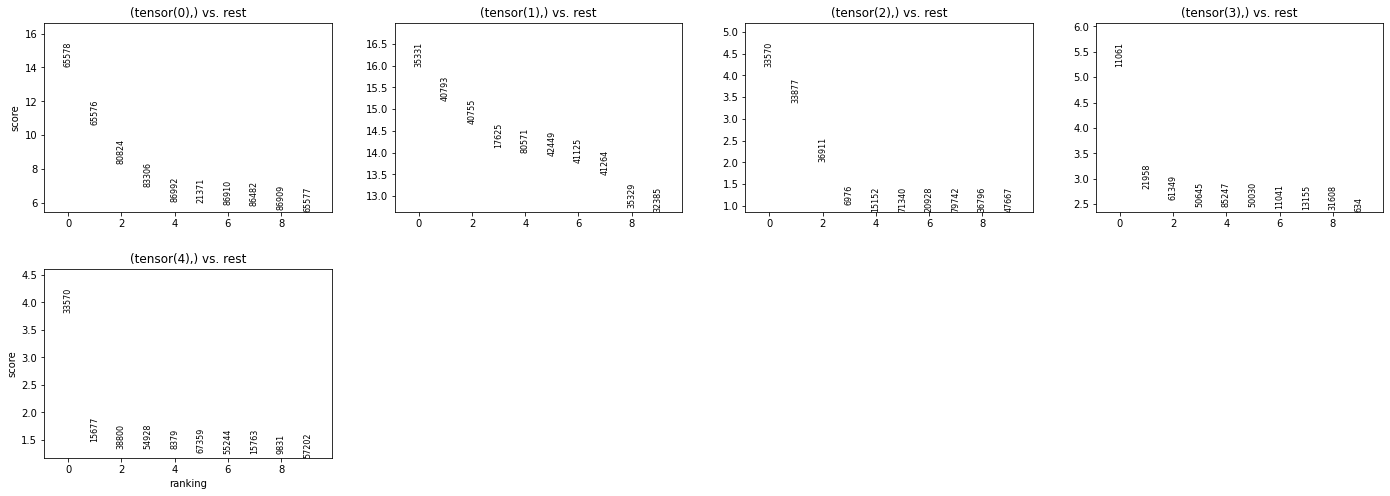

In [14]:
atac_posterior_adata = anndata.AnnData(X=atac_imputation)
atac_posterior_adata.obs['louvain'] = posterior_adata.obs['louvain']
sc.tl.rank_genes_groups(atac_posterior_adata, 'louvain',n_genes=1000)
sc.pl.rank_genes_groups(atac_posterior_adata, n_genes=10, sharey=False)
atac_diff_top_gene_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_set = (atac_diff_top_gene_set['names'])
atac_diff_top_gene_pvalue_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_pvalue_set = (atac_diff_top_gene_pvalue_set['pvals_adj'])
atac_diff_top_gene_foldchange_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_foldchange_set = (atac_diff_top_gene_foldchange_set['logfoldchanges'])